## Neural Style Transfer using tensorflow

In [44]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [3]:
tf.random.set_seed(270)
pp = pprint.PrettyPrinter(indent = 3)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

In [4]:
# Computing the Content Cost

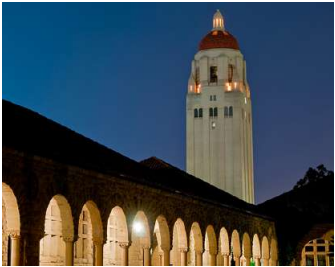

In [38]:
content_image = Image.open(r"C:\Users\Lakshmi\Downloads\Screenshot 2023-06-26 202544.png")
content_image

In [6]:
#  Content Cost Function J_content(C,G)

In [9]:
# def compute_content_cost(content_output, generated_output):
#     a_C = content_output[-1]
#     a_G = generated_output[-1]

#     m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
#     a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])  
#     a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])

#     J_content = tf.reduce_sum(tf.square(a_C - a_G))/(4.0 * n_H * n_W * n_C)

#     return J_content

def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
    
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    
    return J_content

In [10]:

tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
print("J_content = " + str(J_content))

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


In [9]:
# Computing the Style Cost

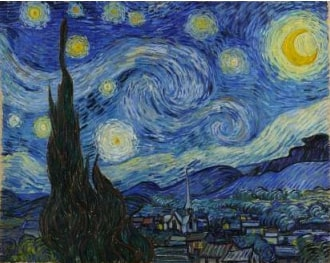

In [11]:
style_image = Image.open(r"C:\Users\Lakshmi\Downloads\Screenshot 2023-06-26 202520.jpg")
style_image

In [76]:
#  Style Matrix

In [13]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [14]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)
print("GA = \n" + str(GA))

GA = 
tf.Tensor(
[[ 63.1888    -26.721277   -7.7320204]
 [-26.721277   12.767579   -2.5158246]
 [ -7.7320204  -2.5158246  23.752384 ]], shape=(3, 3), dtype=float32)


In [79]:
#  Style Cost

In [80]:
# Compute style cost

In [15]:
def compute_layer_style_cost(a_S, a_G):
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))

    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
  
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
      
    return J_style_layer

In [16]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)
print("J_style_layer = " + str(J_style_layer_SG))

J_style_layer = tf.Tensor(14.017804, shape=(), dtype=float32)


In [18]:
# style weights

In [17]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [18]:
vgg.get_layer('block5_pool').output

<KerasTensor: shape=(None, 12, 12, 512) dtype=float32 (created by layer 'block5_pool')>

In [21]:
# Now choose layers to represent the style of the image and assign style costs:

In [19]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [23]:
# compute_style_cost

In [20]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    a_S = style_image_output[1:]

    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
    
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [21]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [22]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

J = tf.Tensor(32.9832, shape=(), dtype=float32)


In [27]:
# Solving the Optimization Problem

In [28]:
# Load the Content Image

(1, 400, 400, 3)


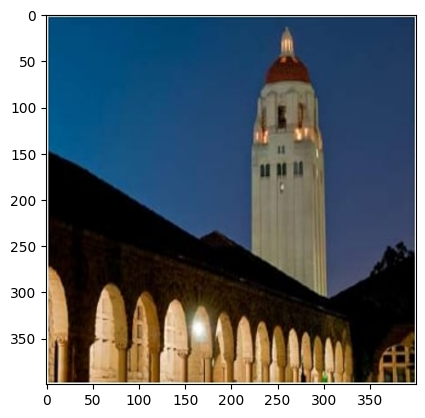

In [40]:
content_image =  np.array(Image.open(r"C:\Users\Lakshmi\Downloads\Screenshot 2023-06-26 202544.jpg").resize((img_size, img_size)))

content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

In [33]:
# Load the Style Image

(1, 400, 400, 3)


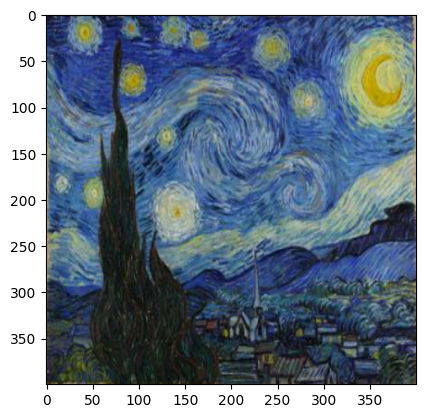

In [24]:
style_image =  np.array(Image.open(r"C:\Users\Lakshmi\Downloads\Screenshot 2023-06-26 202520.png").resize((img_size, img_size)))
style_image_rgb = style_image[:, :, :3]
style_image = tf.constant(np.reshape(style_image_rgb, ((1,) + style_image_rgb.shape)))
print(style_image.shape)
imshow(style_image[0])
plt.show()

In [37]:
# Randomly Initialize the Image to be Generated

(1, 400, 400, 3)


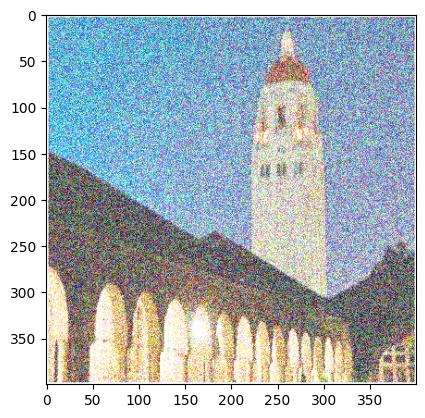

In [41]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [42]:
# Load Pre-trained VGG19 Model

In [26]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # layer_names has 'layer' elements in it.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [27]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [28]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [55]:
# Compute Total Cost

In [29]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.009560819, shape=(), dtype=float32)


In [ ]:
# Compute Style Cost

In [30]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(3295.068, shape=(), dtype=float32)


In [64]:
# Important

In [31]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [32]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [105]:
# train_step

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

In [34]:
def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J

In [35]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
J2 = train_step(generated_image)
print(J2)

tf.Tensor(41124.94, shape=(), dtype=float32)
tf.Tensor(11908.438, shape=(), dtype=float32)


In [144]:
# Train the Model

Epoch 0 


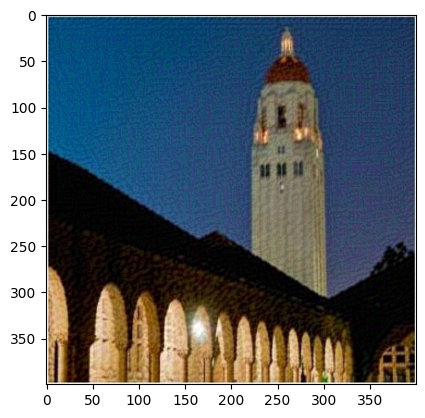

Epoch 10 


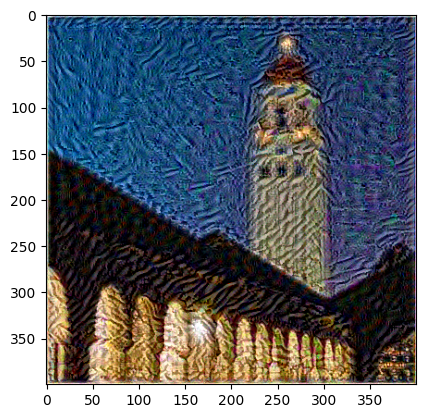

Epoch 20 


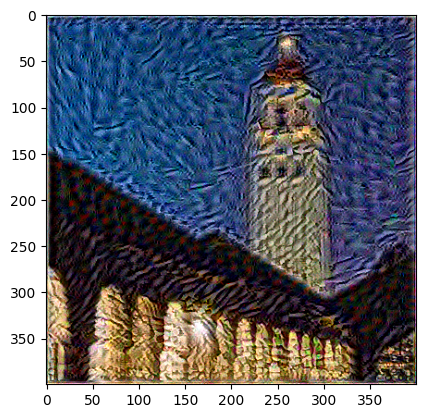

Epoch 30 


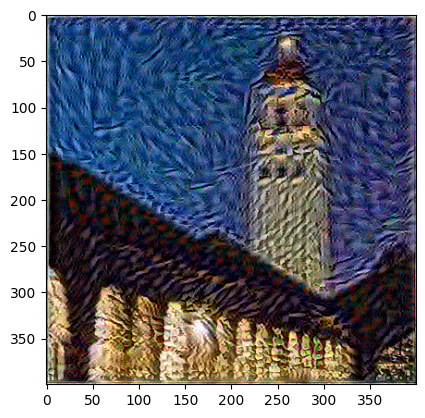

Epoch 40 


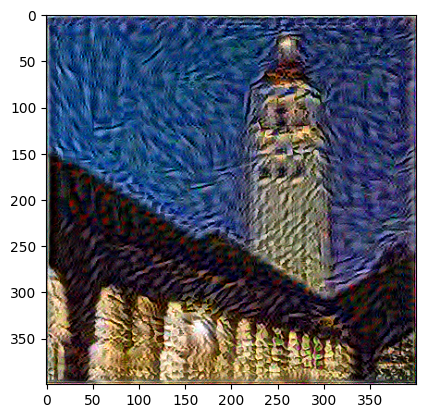

Epoch 50 


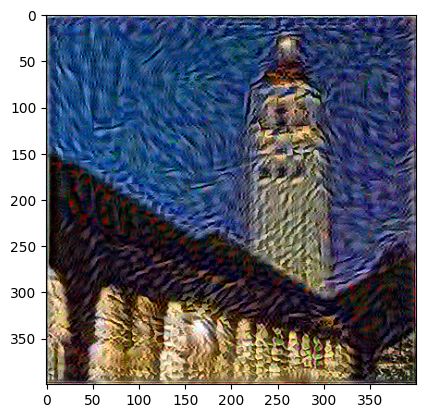

Epoch 60 


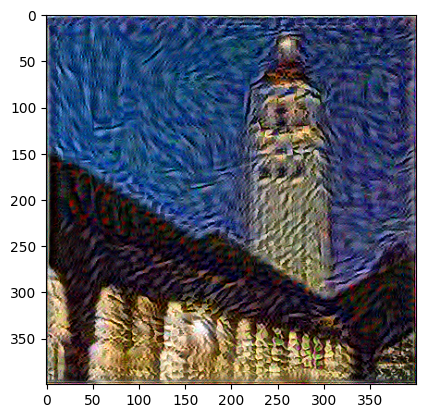

Epoch 70 


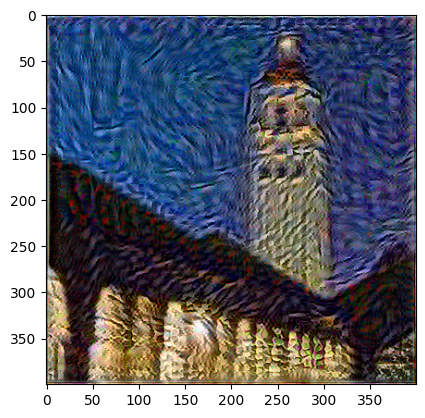

Epoch 80 


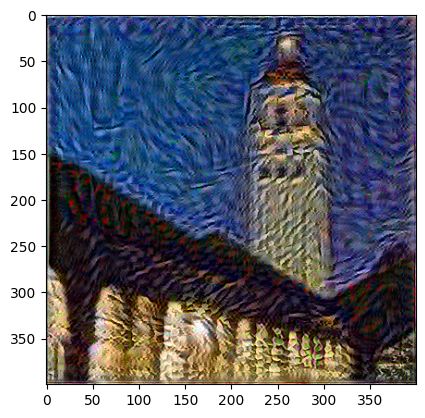

Epoch 90 


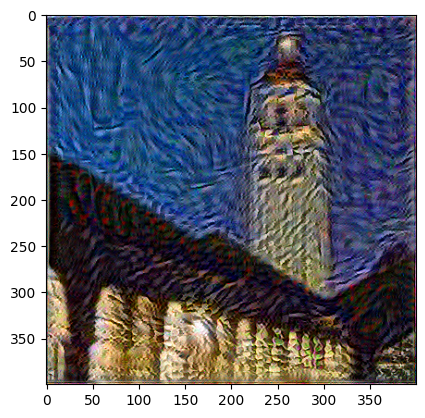

Epoch 100 


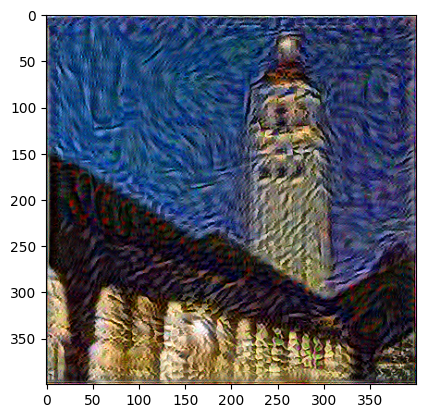

In [42]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 101
for i in range(epochs):
    train_step(generated_image,alpha = 100, beta = 10**2)
    if i % 10 == 0:
        print(f"Epoch {i} ")
    if i % 10 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"C:/Users/Lakshmi/Downloads/nst/image_{i}.jpg")
        plt.show() 

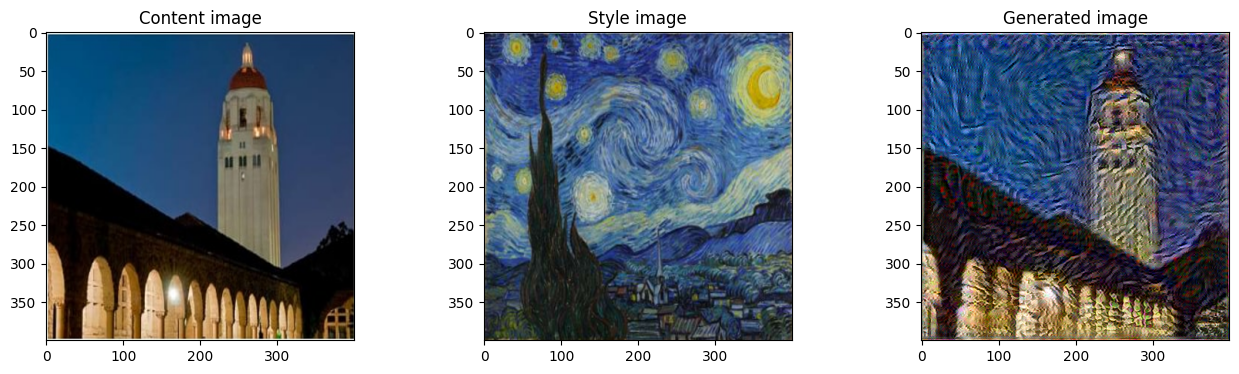

<Figure size 640x480 with 0 Axes>

In [43]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()
plt.savefig("My_Result.jpg")